# Chlorophyll A Data Vis Workbook
### Amy Phung, March 2020

## Setup, Imports, & Globals

### Setup

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from jupyterthemes import jtplot
jtplot.style(theme="monokai", context="notebook", ticks=True, grid=False)

# pd.set_option('display.max_rows', 60)
# pd.set_option('display.max_columns', 30)
# pd.set_option('display.width', None)
# pd.set_option('display.max_colwidth', None)

### Imports

In [95]:
%matplotlib inline
import scipy
import glob
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import netCDF4
import itertools
from datetime import datetime

### Globals

In [56]:
STD_COLUMN_NAMES = ["Src", "Lat", "Long", "Chl-A", "Timestamp", 
                    "Station"]
SAT_COLUMN_NAMES = ["Filename", "Sat Lat", "Sat Long", "Sat Chl-A",
                   "Lat Error", "Long Error", "Time Error"]

## Helper Classes

In [125]:
# Best fit line
class BestFitLine:
    def __init__(self, x, y):
        self.slope, self.intercept, self.r_value, self.p_value, \
            self.std_err = scipy.stats.linregress(x, y)
    
    def computeY(self, x):
        return self.intercept + self.slope*x

## Data Classes

### Main Class

In [126]:
class Dataset:
    """
    Class for datasets with methods to process and reformat raw data
    
    Attributes:
        _source (str): String representing where data came from
        _cols (dict): Dictionary containing lookup for raw column names
        _raw_df (DataFrame): Pandas dataframe containing raw csv data
        df (DataFrame): Pandas dataframe containing formatted data
    """
    def __init__(self, filename, source, column_names):
        self._filename = filename
        self._source = source
        self._cols = column_names
        
    def _loadRaw(self):
        return pd.read_csv(self._filename)
        
    def _processRaw(self):
        pass
    
    def _parseDate(self):
        """ Convert an unformatted timestamp in raw dataset to a Python 
        datetime then to a timestamp. Returns timestamp """
        pass
    
    def _formatData(self):
        self.df["Src"] = self._source
        self.df["Lat"] = self._raw_df[self._cols["Lat"]]
        self.df["Long"] = self._raw_df[self._cols["Long"]]
        self.df["Chl-A"] = self._raw_df[self._cols["Chl-A"]]
        self.df["Timestamp"] = self._raw_df[self._cols["Time"]]
        self.df["Station"] = self._raw_df[self._cols["Station"]]

### BGC Class

In [281]:
class DatasetBGC(Dataset):
    def __init__(self, filename, source, column_names):
        Dataset.__init__(self, filename, source, column_names)
        self._raw_df = self._loadRaw()
        self._processRaw()
        self.df = pd.DataFrame(index=range(0,len(self._raw_df)),
                               columns=STD_COLUMN_NAMES)
        self._formatData()
        
    def _processRaw(self):
        # Remove unused columns
        self._raw_df.dropna(axis=1, how='all', inplace=True) 
        # Drop points missing chlorophyll values
        self._raw_df.dropna(inplace=True) 
        # Drop duplicates (for some reason stations 1-9 like to duplicate)
        self._raw_df.drop_duplicates(inplace=True) 
        # Add in column with station numbers
        self._raw_df["Station Num"] = range(1, len(self._raw_df)+1) 
        # Normalize chlorophyll data
        self._raw_df[self._cols["Chl-A"]] = \
            self._raw_df[self._cols["Chl-A"]]/20. 
        # Add in timestamps
        self._raw_df["Timestamp"] = \
            self._raw_df.apply(self._parseDate, axis=1)
        self._raw_df.reset_index(inplace=True)
        
    def _parseDate(self, df_row):
        time_str = df_row["yyyy-mm-ddThh:mm:ss.sss"]
        year   = int(time_str[0:4])
        month  = int(time_str[5:7])
        day    = int(time_str[8:10])
        hour   = int(time_str[11:13])
        minute = int(time_str[14:16])
        second = int(time_str[17:19])
        
        date = datetime(year, month, day, hour, minute, second)
        timestamp = datetime.timestamp(date)
        return timestamp

### HC Class

In [406]:
class DatasetHC(Dataset):
    def __init__(self, filename, source, column_names):
        self._best_fit_line = None
        self._cal_df = None
        Dataset.__init__(self, filename, source, column_names)

        self._raw_df = self._loadRaw()
        self._processRaw()
        self.df = pd.DataFrame(index=range(0,len(self._raw_df)),
                               columns=STD_COLUMN_NAMES)
        self._formatData()
        
    def _loadRaw(self):
        """Hydrocast data needs tab delimiter and header skipping"""
        # To get data from ODV:
        # Export>Station Data>ODV Spreadsheet file>Uncheck all exports
        return pd.read_csv(self._filename, delimiter="\t",header=27)
        
    def _processRaw(self):
        # Fill in cruise, station, type, date, lat, long, bottom depth 
        # with most recent values
        col_to_fill = ["Cruise", 
                       "Station",
                       "Type",
                       "yyyy-mm-ddThh:mm:ss.sss",
                       "Longitude [degrees_east]",
                       "Latitude [degrees_north]",
                       "Bot. Depth [m]"]
        
        for col in col_to_fill: self._raw_df[col].fillna(method="pad", 
                                                         inplace=True)
        # Add in column with station numbers as integers
        self._raw_df["Station Num"] = \
            self._raw_df["Station"].apply(self._getStationNum) 
        # Add in column with corrected timestamps
        self._raw_df["Corrected Timestamp"] = \
            self._raw_df["yyyy-mm-ddThh:mm:ss.sss"].apply(self._correctHCTimestamp)
        # Only keep points with valid Chl-A fluorescence measurements
        self._raw_df.dropna(subset=["Chl a Fluorescence [V]"], inplace=True)
        # Compute best fit line for calibrated Chl-A data
        self._best_fit_line, self._cal_df = self._calibrateData()
        # Apply best fit line to full dataset
        self._raw_df["Calculated Chl-A"] = \
            self._raw_df["Chl a Fluorescence [V]"].apply( \
            self._best_fit_line.computeY)
        # Add in timestamps
        self._raw_df["Timestamp"] = \
            self._raw_df.apply(self._parseDate, axis=1)
        
        self._raw_df.reset_index(inplace=True)
    
    def _parseDate(self, df_row):
        time_str = df_row["Corrected Timestamp"]
        year   = int(time_str[0:4])
        month  = int(time_str[5:7])
        day    = int(time_str[8:10])
        hour   = int(time_str[11:13])
        minute = int(time_str[14:16])
        
        date = datetime(year, month, day, hour, minute)
        timestamp = datetime.timestamp(date)
        return timestamp
    
    def _formatData(self):
        """Hydrocast data has additional depth column to add to dataset"""
        self.df["Src"] = self._source
        self.df["Lat"] = self._raw_df[self._cols["Lat"]]
        self.df["Long"] = self._raw_df[self._cols["Long"]]
        self.df["Chl-A"] = self._raw_df[self._cols["Chl-A"]]
        self.df["Timestamp"] = self._raw_df[self._cols["Time"]]
        self.df["Station"] = self._raw_df[self._cols["Station"]]
        self.df["Depth"] = self._raw_df["Depth [m]"]
        
    # Other Functions
    def _getStationNum(self, station_name):
        """Parses station name from hydrocast dataset and returns an int 
        representing station number.

        Args:
            station_name (str): Hydrocast station name in the format S290-###-HC

        Returns:
            station_num (int): Hydrocast station number
        """
        return int(station_name[5:8])
    
    def _correctHCTimestamp(self, timestamp):
        """Applies correction to HC timestamp - 2020 is incorrectly written as
        0020, so this function returns a new timestamp in the correct format

        Args:
            timestamp (str): Incorrect timestamp from hydrocast data

        Returns:
            corrected_timestamp (str): Corrected timestamp
        """
        new_timestamp = "2020" + timestamp[4:]
        return new_timestamp
        
    def _calibrateData(self):
        """Computes best fit line between fluorescence and Chl-A value
        for hydrocast data"""
        # Create calibration dataset
        cal_df = self._raw_df.dropna(subset=["Chl-a [ug/L]"])
        # Compute best fit line
        hc_fit_line = BestFitLine(cal_df["Chl a Fluorescence [V]"],
                                  cal_df["Chl-a [ug/L]"])
        return hc_fit_line, cal_df
    
    # Visualizations
    def visualizeCalibration(self):
        plt.scatter(self._cal_df["Chl a Fluorescence [V]"], 
                    self._cal_df["Chl-a [ug/L]"], 
                    c=self._cal_df["Depth [m]"],
                    marker='.')
        plt.colorbar()
        plt.xlabel("Chl a Fluorescence [V]")
        plt.ylabel("Chl-a [ug/L]")
        plt.title("Hydrocast Chl-A Best Fit Calibration Line")

        xp = np.linspace(self._cal_df["Chl a Fluorescence [V]"].min(),
                         self._cal_df["Chl a Fluorescence [V]"].max(),
                         100)
        plt.plot(xp, self._best_fit_line.computeY(xp))

        

### Flow-through Class

In [502]:
class DatasetFT(Dataset):
    """
    Class for flow-through data

    Needs hydrocast data passed in for calibration
    ml_depth = mixed layer depth - determines which hydrocast points can be 
        included in calibration set
    """
    def __init__(self, filename, source, column_names, hc_df, ml_depth=25):
        self._hc_df = hc_df
        self._ml_depth = ml_depth
        self._best_fit_line = None
        self._cal_df = None
        Dataset.__init__(self, filename, source, column_names)
        self._raw_df = self._loadRaw()
        self._processRaw()
#         self.df = pd.DataFrame(index=range(0,len(self._raw_df)),
#                        columns=STD_COLUMN_NAMES)
#         self._formatData()
        
    def _processRaw(self):
        # Remove unnecessary columns
#         self._raw_df.dropna(axis=1, inplace=True) 
#         self._raw_df
        # Add in column with properly formatted latitude
        self._raw_df["Latitude"] = \
            self._raw_df["GPS-nav-Lat"].apply(self._computeDegreesDecimalFT)
        # Add in column with properly formatted longitude
        self._raw_df["Longitude"] = \
            self._raw_df["GPS-nav-Lon"].apply(self._computeDegreesDecimalFT)
        # Add in timestamps
        self._raw_df["Timestamp"] = \
            self._raw_df.apply(self._parseDate, axis=1)
        
        self._raw_df.reset_index(inplace=True)
        
        self._best_fit_line, self._cal_df = self._calibrateData()
    
    def _parseDate(self, df_row):
        date = df_row["Date"]
        time = df_row["Time"]
        
        year   = int(date[6:10])
        month  = int(date[0:2])
        day    = int(date[3:5])
        hour   = int(time[0:2])
        minute = int(time[3:5])
        second = int(time[6:8])

        date = datetime(year, month, day, hour, minute, second)
        timestamp = datetime.timestamp(date)
        return timestamp
    
    # Calibration
    def _calibrateData(self):
        """Computes best fit line between fluorescence and Chl-A value
        for flow-through data"""
        # Initialize empty calibration dataframe
        cal_col = list(self._hc_df.columns) \
                  + ["FT Timestamp", "FT Chlorophyll", "Time Delta"]
        _cal_df = pd.DataFrame(index=range(0,len(self._hc_df)), \
                                    columns=cal_col)
        # Fill in data from hydrocast
        _cal_df.update(self._hc_df)
        # Filter out data outside mixed layer depth
        _cal_df = _cal_df[_cal_df["Depth"] <= self._ml_depth]
        _cal_df.reset_index(inplace=True)
        # Lookup nearest flow-through point
        _cal_df[["FT Timestamp", "FT Chlorophyll", "Time Delta"]] = \
            _cal_df.apply(self._lookupNearestPt, axis=1)
        # Compute best fit line
        ft_fit_line = BestFitLine(_cal_df["FT Chlorophyll"].astype(float),
                                  _cal_df["Chl-A"].astype(float))
        return ft_fit_line, _cal_df

    def _lookupNearestPt(self, df_row):
        deltas = abs(df_row["Timestamp"] - self._raw_df["Timestamp"])
        nearest_idx = deltas.argmin()
        
        timestamp = self._raw_df["Timestamp"][nearest_idx]
        chl = self._raw_df["Fluor-Chl-avg-1-min-Value"][nearest_idx]
        delta = deltas.min()
        return pd.Series([timestamp, chl, delta])
    
    # Other Functions
    def _computeDegreesDecimalFT(self, gps_val):
        """Converts latitude or longitude value from flow-through dataset
        into a compatible numerical value. 
        Example input values:
            3650.1777S = 36 degrees, 50.1777 minutes South
            4136.8718S = 41 degrees, 36.8718 minutes South
            17446.9143E = 174 degrees, 46.9143 minutes East
            17959.6199W = 179 degrees, 59.6199 minutes West

        Args:
            gps_val (str): Input latitude or longitude value to be converted

        Output:
            gps_num (float): GPS input value in decimal form. Latitude range
                [-90, 90], Longitude range [0, 360]
        """
        dec_idx = gps_val.find(".") 
        degrees = int(gps_val[:dec_idx-2]) # Degrees
        minutes = float(gps_val[dec_idx-2:dec_idx+4]) # Minutes
        decimal = minutes/60.

        gps_num = degrees + decimal

        if gps_val[-1] == "S":
            gps_num = (gps_num*-1) 
        elif gps_val[-1] == "W":
            gps_num = (gps_num*-1) % 360 # Convert from [-180 180] to [0 360]

        return gps_num
    
    # Visualizations
    def visualizeCalibration(self):
        plt.scatter(self._cal_df["FT Chlorophyll"], 
                    self._cal_df["Chl-A"], 
                    c=self._cal_df["Depth"],
                    marker='.')
        
        plt.colorbar()
        plt.xlabel("Flow-Through Chl a Fluorescence [V]")
        plt.ylabel("Hydrocast Chl-a [ug/L]")
        plt.title("Flow-Through Chl-A Best Fit Calibration Line")

        xp = np.linspace(self._cal_df["FT Chlorophyll"].min(),
                         self._cal_df["FT Chlorophyll"].max(),
                         100)
        plt.plot(xp, self._best_fit_line.computeY(xp))

0.34600831166839285


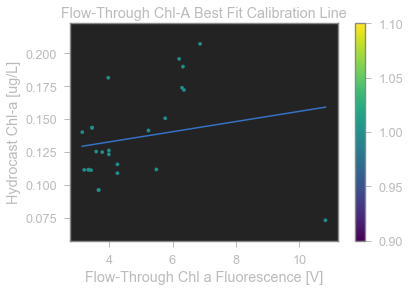

In [503]:
ft_cols = {"Lat": "Latitude",
            "Long": "Longitude",
            "Chl-A": "Wind-Dir",
            "Time": "Timestamp",
            "Station": "Wind-Dir"}
ft_data = DatasetFT("data/Event60sec_003.elg", "FT", ft_cols, hc_data.df, ml_depth=1)
ft_data._cal_df
ft_data.visualizeCalibration()
print(ft_data._best_fit_line.p_value)

In [506]:
ft_data._cal_df[ft_data._cal_df["FT Chlorophyll"] > 8]


,index,Src,Lat,Long,Chl-A,Timestamp,Station,Depth,FT Timestamp,FT Chlorophyll,Time Delta
12,5063,HC,-34.977,175.299,0.0733401,1.58295e+09,14,1,1.582951e+09,10.83,4.0


In [505]:
ft_data._cal_df


,index,Src,Lat,Long,Chl-A,Timestamp,Station,Depth,FT Timestamp,FT Chlorophyll,Time Delta
0,0,HC,-36.357,175.172,0.141415,1.58202e+09,1,1,1.582019e+09,5.24,14.0
1,39,HC,-35.786,174.902,0.189812,1.58217e+09,2,1,1.582172e+09,6.33,5.0
2,147,HC,-35.488,175.007,0.17382,1.58213e+09,3,1,1.582131e+09,6.30,16.0
3,386,HC,-35.337,174.832,0.140153,1.58226e+09,4,1,1.582261e+09,3.15,5.0
4,570,HC,-34.976,174.614,0.126265,1.58222e+09,5,1,1.582217e+09,3.99,17.0
5,1032,HC,-34.906,174.735,0.125002,1.58248e+09,6,1,1.582477e+09,3.78,4.0
6,1623,HC,-34.225,175.402,0.111325,1.58261e+09,7,1,1.582606e+09,3.43,19.0
7,2213,HC,-33.603,175.848,0.0963011,1.58269e+09,8,1,1.582692e+09,3.66,23.0
8,2781,HC,-33.893,173.875,0.0963011,1.58278e+09,10,1,1.582779e+09,3.67,26.0
9,3349,HC,-33.777,174.053,0.125423,1.58274e+09,11,1,1.582737e+09,3.59,29.0


## Main Script

In [407]:
bgc_cols = {"Lat": "Latitude [degrees_north]",
            "Long": "Longitude [degrees_east]",
            "Chl-A": "Integral_0 { Chlorophyll-A (original) } * d_Pressure (original) [mg m~^-~^3 * decibar] @ Pressure (original) [decibar]=20.0",
            "Time": "Timestamp",
            "Station": "Station Num"}
bgc_data = DatasetBGC("data/argo-isosurface-data.csv", "BGC", bgc_cols)
bgc_data.df

,Src,Lat,Long,Chl-A,Timestamp,Station
0,BGC,-32.465,185.24200,0.598395,1.501384e+09,1
1,BGC,-32.267,185.30000,0.628195,1.502250e+09,2
2,BGC,-32.298,185.25600,0.415292,1.503110e+09,3
3,BGC,-32.560,185.32600,0.514820,1.503982e+09,4
4,BGC,-32.979,185.25101,0.363909,1.504851e+09,5
...,...,...,...,...,...,...
88,BGC,-42.033,185.93600,0.321619,1.577313e+09,89
89,BGC,-41.869,186.26900,0.333278,1.578173e+09,90
90,BGC,-41.677,186.60600,0.228063,1.579034e+09,91
91,BGC,-41.507,186.82600,0.214175,1.579899e+09,92


1.0545750053408705e-10


,Src,Lat,Long,Chl-A,Timestamp,Station,Depth
0,HC,-36.357,175.172,0.141415,1.582019e+09,1,1.0
1,HC,-36.357,175.172,0.143940,1.582019e+09,1,2.0
2,HC,-36.357,175.172,0.148569,1.582019e+09,1,3.0
3,HC,-36.357,175.172,0.146044,1.582019e+09,1,4.0
4,HC,-36.357,175.172,0.146044,1.582019e+09,1,5.0
...,...,...,...,...,...,...,...
11262,HC,-40.086,178.105,0.427334,1.583859e+09,29,60.0
11263,HC,-40.086,178.105,0.196705,1.583859e+09,29,99.0
11264,HC,-40.086,178.105,0.095367,1.583859e+09,29,199.0
11265,HC,-40.086,178.105,0.094504,1.583859e+09,29,297.0


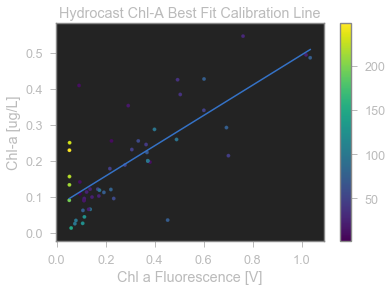

In [408]:
hc_cols = {"Lat": "Latitude [degrees_north]",
           "Long": "Longitude [degrees_east]",
           "Time": "Timestamp",
           "Chl-A": "Calculated Chl-A",
           "Station": "Station Num"}
hc_data = DatasetHC("data/data_from_S290-CTD-HC-2.txt", "HC", hc_cols)
print(hc_data._best_fit_line.p_value)
hc_data.visualizeCalibration()
hc_data.df

In [317]:
a = pd.DataFrame({"a":[2,53,2], "b":[3,7,5]})
b = list(a.columns)

In [319]:
b + ["a", "b"]

['a', 'b', 'a', 'b']

In [320]:
b


['a', 'b']